# COMP2002 Assessment

This notebook will contain demonstrations of:
- Regression models trained to predict the Fire Weather Index (FWI) at a given time based on 12 numerical inputs from records of forest fires in 2 regions of Algeria.
- Optimisers designed to optimise routes between cities in the Travelling Salesman Problem.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from random import shuffle, randint

### Regression

In [2]:
# Load forest file data using Pandas
forest_fire_region_1_data = pd.read_csv("./data/AlgerianFF_Region1.csv")
forest_fire_region_2_data = pd.read_csv("./data/AlgerianFF_Region2.csv")

In [3]:
# Copy data to avoid making permanent unrecoverable changes to the original
forest_fire_region_1_training_data = forest_fire_region_1_data.copy()
forest_fire_region_2_training_data = forest_fire_region_2_data.copy()

# Merge datasets into one set
forest_fire_data = pd.concat([forest_fire_region_1_training_data, forest_fire_region_2_training_data])

# Seperate FWI from the rest of the data, as this is the output we want to generate
forest_fire_targets = np.array(forest_fire_data.pop("FWI"))

In [4]:
# Create scaler for merged dataset
ffr_scaler = MinMaxScaler()

# Fit scaler on merged dataset
ffr_scaler.fit(forest_fire_data)

# Normalise dataset using the now fitted scaler
scaled_forest_fire_data = ffr_scaler.transform(forest_fire_data)
print(scaled_forest_fire_data.ptp(axis=0))

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# Split data into training, testing and validation sets
forest_fire_training_data, forest_fire_testing_data, forest_fire_training_targets, forest_fire_testing_targets = train_test_split(scaled_forest_fire_data, forest_fire_targets)
forest_fire_training_data, forest_fire_validation_data, forest_fire_training_targets, forest_fire_validation_targets = train_test_split(forest_fire_training_data, forest_fire_training_targets)

In [6]:
# Initialise regressor objects
random_forest_regressor = RandomForestRegressor(n_estimators=100)
# Set activaion to tanh and solver to lbfgs for better performance on smaller datasets
neural_network_regressor = MLPRegressor(solver='lbfgs', activation='tanh', max_iter=100)
# Set kernel to linear for better performance
support_vector_regressor = SVR(kernel='linear', C=13.0)

In [7]:
# Train regressors on training data
random_forest_regressor.fit(forest_fire_training_data, forest_fire_training_targets)
neural_network_regressor.fit(forest_fire_training_data, forest_fire_training_targets)
support_vector_regressor.fit(forest_fire_training_data, forest_fire_training_targets)

SVR(C=13.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [8]:
def test_on_point_in_dataset(regressor, point_index):
    prediction = regressor.predict(forest_fire_training_data[point_index].reshape(1, 12))
    prediction_string = f"Real: {forest_fire_training_targets[point_index]}\nPredicted by regressor: {prediction[0]}"
    return prediction_string

In [9]:
# Use trained random forest regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(random_forest_regressor, 0))

Real: 15.3
Predicted by regressor: 15.206999999999983


In [10]:
# Use trained neural network regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(neural_network_regressor, 0))

Real: 15.3
Predicted by regressor: 15.558492128660976


In [11]:
# Use trained support vector regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(support_vector_regressor, 0))

Real: 15.3
Predicted by regressor: 14.627968488375144


In [12]:
def get_cross_validation_scores(regressor, testing_data, testing_targets):
    # Since this normally returns a negative version of the scores, negate this to make positive again
    return -np.array(cross_val_score(regressor, testing_data, testing_targets, cv=5, scoring='neg_mean_absolute_error'))

In [13]:
def plot_cross_validation(cross_validation_data):
    # Set up labels
    regressor_labels = ["Random Forest Regressor", "Neural Network Regressor", "Support Vector Regressor"]
    # Set figsize to avoid labels overlapping
    plt.figure(figsize=(9.6, 7.2))
    # Plot data with labels
    plt.boxplot(cross_validation_data, labels=regressor_labels)
    plt.hlines(0, 0, 4, label="Best possible score")
    
    
    plt.show()

In [14]:
random_forest_scores = get_cross_validation_scores(random_forest_regressor, forest_fire_validation_data, forest_fire_validation_targets)
neural_network_scores = get_cross_validation_scores(neural_network_regressor, forest_fire_validation_data, forest_fire_validation_targets)
support_vector_scores = get_cross_validation_scores(support_vector_regressor, forest_fire_validation_data, forest_fire_validation_targets)

[1.0148     0.72566667 1.07177778 1.29488889 2.62544444] [0.71538921 0.25531768 0.27814311 0.34708603 0.27473746] [0.84709986 0.6641897  0.57604824 0.72832429 0.8027949 ]


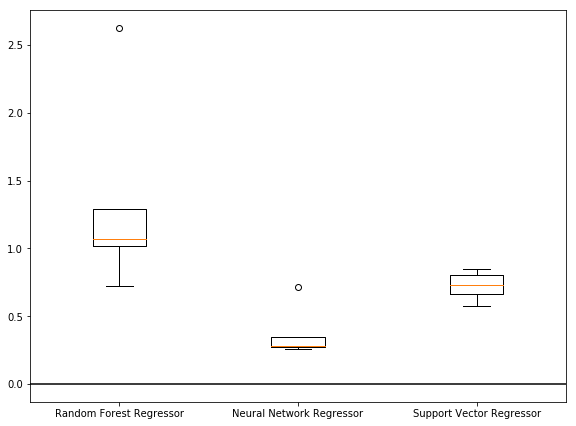

In [15]:
print(random_forest_scores, neural_network_scores, support_vector_scores)
plot_cross_validation((random_forest_scores, neural_network_scores, support_vector_scores))

### Optimisation

In [16]:
cities_long_filename = "./data/cities.txt"
cities_short_filename = "./data/cities_short.txt"
distance_long_filename = "./data/distances.csv"
distance_short_filename = "./data/distances_short.csv"

In [17]:
def get_total_distance_of_route(route, distance_data):
    total_distance = 0
    for city_index in range(0, len(route) - 1):
        # Get the name of the city being started from and the city going to
        city_from, city_to = route[city_index], route[city_index + 1]
        # Get the distance between these two cities
        single_distance = distance_data[city_from][city_to]
        # Add to total distance
        total_distance += single_distance
    
    return total_distance

In [18]:
def get_cities(cities_filename):
    with open(cities_filename) as cities_file:
        # Read and use splitlines rather than readlines to avoid \n characters on the end of city names
        cities = cities_file.read().splitlines()
        return cities

In [19]:
def get_distance_data(cities_filename, distance_filename):
    # Get cities
    cities = get_cities(cities_filename)
    # Read CSV and specify seperator in order to use faster C implementation of CSV reader
    distance = pd.read_csv(distance_filename, sep=",", names=cities)
    # Set index names seperately as this is not an option in the read_csv method
    distance.index = cities
    
    return (cities, distance)

In [20]:
cities_long, distance_long = get_distance_data(cities_long_filename, distance_long_filename)
cities_short, distance_short = get_distance_data(cities_short_filename, distance_short_filename)

display(distance_long)
display(distance_short)

,Cardiff,Swansea,Bangor,Glasgow,Edinburgh,Inverness,Aberdeen,London,Plymouth,Bristol,Southampton,Norwich,Birmingham,Manchester,Liverpool,Cambridge,Brighton,Oxford,Newcastle,Leeds
Cardiff,0.0,41.2,180.0,392.0,394.0,547,525,151.0,152,53.0,134.0,266.0,124.0,188.0,200.0,202.0,191.0,118.0,323.0,227.0
Swansea,41.2,0.0,157.0,428.0,430.0,583,560,187.0,187,92.1,169.0,302.0,160.0,224.0,165.0,242.0,227.0,154.0,358.0,263.0
Bangor,180.0,157.0,0.0,295.0,297.0,451,428,266.0,347,233.0,291.0,307.0,152.0,96.3,70.0,247.0,325.0,210.0,240.0,139.0
Glasgow,392.0,428.0,295.0,0.0,46.5,168,145,414.0,485,372.0,429.0,376.0,290.0,216.0,221.0,357.0,463.0,364.0,152.0,221.0
Edinburgh,394.0,430.0,297.0,46.5,0.0,156,127,403.0,487,373.0,431.0,373.0,292.0,217.0,222.0,354.0,465.0,366.0,120.0,218.0
Inverness,547.0,583.0,451.0,168.0,156.0,0,104,561.0,641,528.0,585.0,533.0,447.0,373.0,378.0,514.0,619.0,521.0,282.0,378.0
Aberdeen,525.0,560.0,428.0,145.0,127.0,104,0,539.0,620,506.0,563.0,510.0,425.0,351.0,355.0,491.0,597.0,499.0,254.0,356.0
London,151.0,187.0,266.0,414.0,403.0,561,539,0.0,215,118.0,80.1,118.0,126.0,208.0,221.0,64.0,53.5,56.1,290.0,195.0
Plymouth,152.0,187.0,347.0,485.0,487.0,641,620,215.0,0,121.0,152.0,359.0,211.0,281.0,293.0,299.0,217.0,205.0,416.0,321.0
Bristol,53.0,92.1,233.0,372.0,373.0,528,506,118.0,121,0.0,101.0,246.0,97.5,168.0,180.0,186.0,159.0,85.2,302.0,207.0


,Plymouth,Bristol,London,Cardiff,Edinburgh
Plymouth,0,394,151,152,53
Bristol,394,0,403,487,373
London,151,403,0,215,118
Cardiff,152,487,215,0,121
Edinburgh,53,373,118,121,0


In [21]:
default_long_distance = get_total_distance_of_route(cities_long, distance_long)
default_short_distance = get_total_distance_of_route(cities_short, distance_short)
print(default_long_distance)
print(default_short_distance)

3037.4999999999995
1133


In [22]:
def get_random_route(cities_filename):
    cities = get_cities(cities_filename)
    shuffle(cities)
    return cities

In [23]:
for i in range(0, 3):
    random_long = get_random_route(cities_long_filename)
    print(random_long)
    print(get_total_distance_of_route(random_long, distance_long))
    
for i in range(0, 3):
    random_short = get_random_route(cities_short_filename)
    print(random_short)
    print(get_total_distance_of_route(random_short, distance_short))

['Newcastle', 'Manchester', 'Liverpool', 'Bangor', 'Aberdeen', 'Inverness', 'Southampton', 'Swansea', 'Plymouth', 'Cardiff', 'Glasgow', 'Oxford', 'London', 'Norwich', 'Cambridge', 'Brighton', 'Bristol', 'Birmingham', 'Edinburgh', 'Leeds']
3758.9
['Southampton', 'Plymouth', 'Inverness', 'Cardiff', 'Edinburgh', 'Liverpool', 'Leeds', 'Oxford', 'Aberdeen', 'Birmingham', 'Bangor', 'Cambridge', 'Bristol', 'Manchester', 'London', 'Glasgow', 'Swansea', 'Brighton', 'Newcastle', 'Norwich']
5758.0
['Edinburgh', 'Liverpool', 'Plymouth', 'Aberdeen', 'Bangor', 'Birmingham', 'Newcastle', 'Norwich', 'Southampton', 'London', 'Glasgow', 'Oxford', 'Manchester', 'Leeds', 'Cardiff', 'Inverness', 'Swansea', 'Brighton', 'Cambridge', 'Bristol']
5338.7
['London', 'Edinburgh', 'Bristol', 'Cardiff', 'Plymouth']
1130
['Plymouth', 'Bristol', 'London', 'Edinburgh', 'Cardiff']
1036
['Edinburgh', 'Cardiff', 'London', 'Bristol', 'Plymouth']
1133


In [24]:
def less_than_or_equal(score_1, score_2):
    return score_1 <= score_2

In [25]:
def swap(route):
    new_route = route.copy()
    
    index_1 = randint(0, len(new_route) - 1)
    index_2 = randint(0, len(new_route) - 1)
    
    new_route[index_1], new_route[index_2] = new_route[index_2], new_route[index_1]
    
    return new_route

In [26]:
def ruin_and_recreate(route):
    new_route = route.copy()
    
    shuffle(new_route)
    return new_route

In [27]:
def solve(parent_solution, parent_solution_score, distance, mutation_function, archive):
    
    # Mutate parent solution to create child
    child_solution = mutation_function(parent_solution)
    
    # Evaluate child
    child_solution_score = get_total_distance_of_route(child_solution, distance)
    
    # Compare parent and child, if child solution is better then
    if less_than_or_equal(child_solution_score, parent_solution_score):
        best_solution = child_solution
        best_solution_score = child_solution_score
    else:
        best_solution = parent_solution
        best_solution_score = parent_solution_score
    
    archive.append(best_solution_score)
    return best_solution, best_solution_score, archive
        

In [28]:
def optimise(cities_filename, distance_filename, mutation_function, iterations):
    
    cities, distance = get_distance_data(cities_filename, distance_filename)
    # Generate random solution to start with
    best_solution = get_random_route(cities_filename)
    
    # Evaluate random solution
    best_solution_score = get_total_distance_of_route(best_solution, distance)
    
    archive = []
    
    for iteration in range(0, iterations):
        # Create new solutions
        best_solution, best_solution_score, archive = solve(best_solution, best_solution_score, distance, mutation_function, archive)
    
    return best_solution, best_solution_score, np.array(archive)
    

In [29]:
best_long_swap_solution, best_long_swap_solution_score, long_swap_archive = optimise(cities_long_filename, distance_long_filename, swap, 30)
print(best_long_swap_solution)
print(best_long_swap_solution_score)
print(long_swap_archive)

['Newcastle', 'Aberdeen', 'Inverness', 'Edinburgh', 'Norwich', 'Manchester', 'Swansea', 'Cardiff', 'Bangor', 'Liverpool', 'Glasgow', 'Birmingham', 'Bristol', 'Southampton', 'Oxford', 'Brighton', 'Leeds', 'Cambridge', 'London', 'Plymouth']
3177.6
[5064.3 5064.3 5064.3 5064.3 5064.3 5064.3 4825.5 4825.5 4670.3 4670.3
 4670.3 3931.3 3931.3 3741.3 3741.3 3741.3 3717.3 3717.3 3717.3 3494.1
 3494.1 3465.1 3465.1 3465.1 3465.1 3465.1 3332.1 3177.6 3177.6 3177.6]


In [30]:
best_long_rr_solution, best_long_rr_solution_score, long_rr_archive = optimise(cities_long_filename, distance_long_filename, ruin_and_recreate, 30)
print(best_long_rr_solution)
print(best_long_rr_solution_score)
print(long_rr_archive)

['Bristol', 'Swansea', 'Glasgow', 'Liverpool', 'Bangor', 'Plymouth', 'Inverness', 'Aberdeen', 'Edinburgh', 'London', 'Cambridge', 'Manchester', 'Cardiff', 'Birmingham', 'Leeds', 'Brighton', 'Oxford', 'Southampton', 'Norwich', 'Newcastle']
3993.0
[4751.1 4523.9 4498.8 4498.8 4498.8 4498.8 4498.8 4498.8 4498.8 4498.8
 4498.8 4498.8 4498.8 4498.8 4498.8 4498.8 4498.8 4405.4 4405.4 4405.4
 4405.4 4405.4 4405.4 4405.4 4405.4 3993.  3993.  3993.  3993.  3993. ]


In [31]:
best_short_swap_solution, best_short_swap_solution_score, short_swap_archive = optimise(cities_short_filename, distance_short_filename, swap, 30)
print(best_short_swap_solution)
print(best_short_swap_solution_score)
print(short_swap_archive)

['Bristol', 'London', 'Edinburgh', 'Plymouth', 'Cardiff']
726
[827 827 827 827 827 827 728 728 728 728 728 728 728 728 728 728 728 728
 728 728 726 726 726 726 726 726 726 726 726 726]


In [32]:
best_short_rr_solution, best_short_rr_solution_score, short_rr_archive = optimise(cities_short_filename, distance_short_filename, ruin_and_recreate, 30)
print(best_short_rr_solution)
print(best_short_rr_solution_score)
print(short_rr_archive)

['Cardiff', 'Plymouth', 'Edinburgh', 'London', 'Bristol']
726
[1052 1052 1052 1052  792  780  780  780  780  780  780  780  780  780
  780  726  726  726  726  726  726  726  726  726  726  726  726  726
  726  726]


In [33]:
def run_experiment(cities_filename, distance_filename, mutation):
    all_archives = []
    for i in range(30):
        best_solution, best_solution_score, archive = optimise(cities_filename, distance_filename, mutation, 100)
        all_archives.append(archive)
    
    return np.array(all_archives)

In [34]:
long_swap_experiment = run_experiment(cities_long_filename, distance_long_filename, swap)
long_rr_experiment = run_experiment(cities_long_filename, distance_long_filename, ruin_and_recreate)
short_swap_experiment = run_experiment(cities_short_filename, distance_short_filename, swap)
short_rr_experiment = run_experiment(cities_short_filename, distance_short_filename, ruin_and_recreate)

In [35]:
def plot_experiment_data(swap_experiment, rr_experiment, title):
    plt.figure(figsize=(19.2, 14.4))
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Distance travelled")
    
    swap_mean = swap_experiment.mean(axis=0)
    swap_max = swap_experiment.max(axis=0)
    swap_min = swap_experiment.min(axis=0)

    rr_mean = rr_experiment.mean(axis=0)
    rr_max = rr_experiment.max(axis=0)
    rr_min = rr_experiment.min(axis=0)

    plt.plot(swap_mean, "bo-", markersize=8, label="Swap - mean")
    plt.plot(swap_max, "b^-", markersize=8, label="Swap - max")
    plt.plot(swap_min, "bv-", markersize=8, label="Swap - min")
    plt.plot(rr_mean, "ro-", markersize=8, label="Ruin and recreate - mean")
    plt.plot(rr_max, "r^-", markersize=8, label="Ruin and recreate - max")
    plt.plot(rr_min, "rv-", markersize=8, label="Ruin and recreate - min")
    plt.fill_between(range(len(swap_mean)), swap_mean, swap_max, alpha=0.2, color="blue")
    plt.fill_between(range(len(swap_mean)), swap_mean, swap_min, alpha=0.2, color="blue")
    plt.fill_between(range(len(rr_mean)), rr_mean, rr_max, alpha=0.2, color="red")
    plt.fill_between(range(len(rr_mean)), rr_mean, rr_min, alpha=0.2, color="red")

    plt.legend()

    plt.tight_layout()

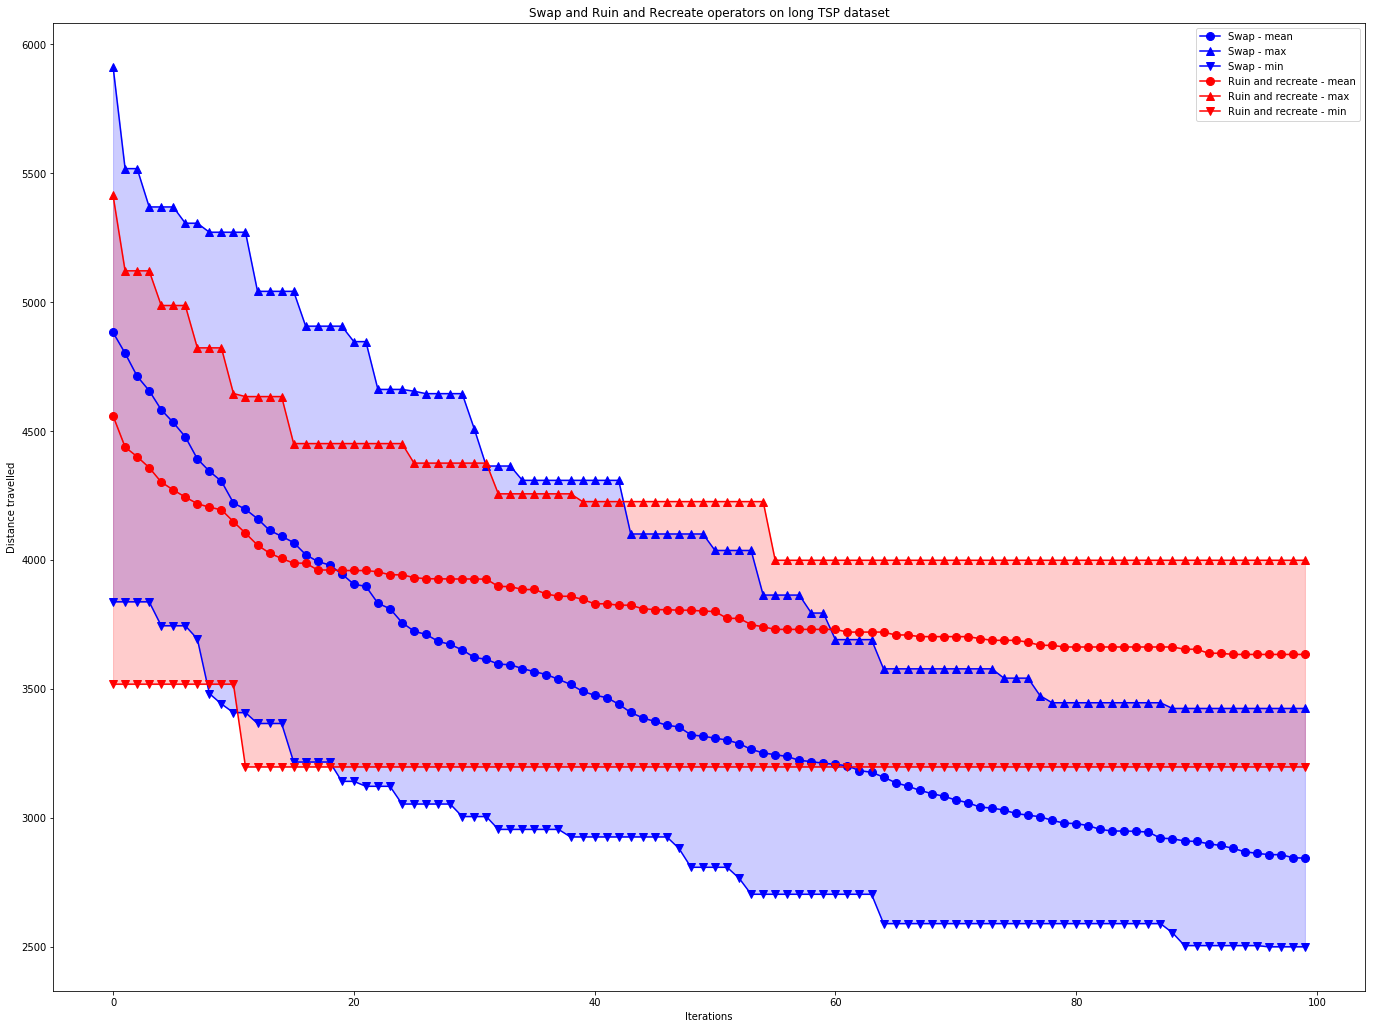

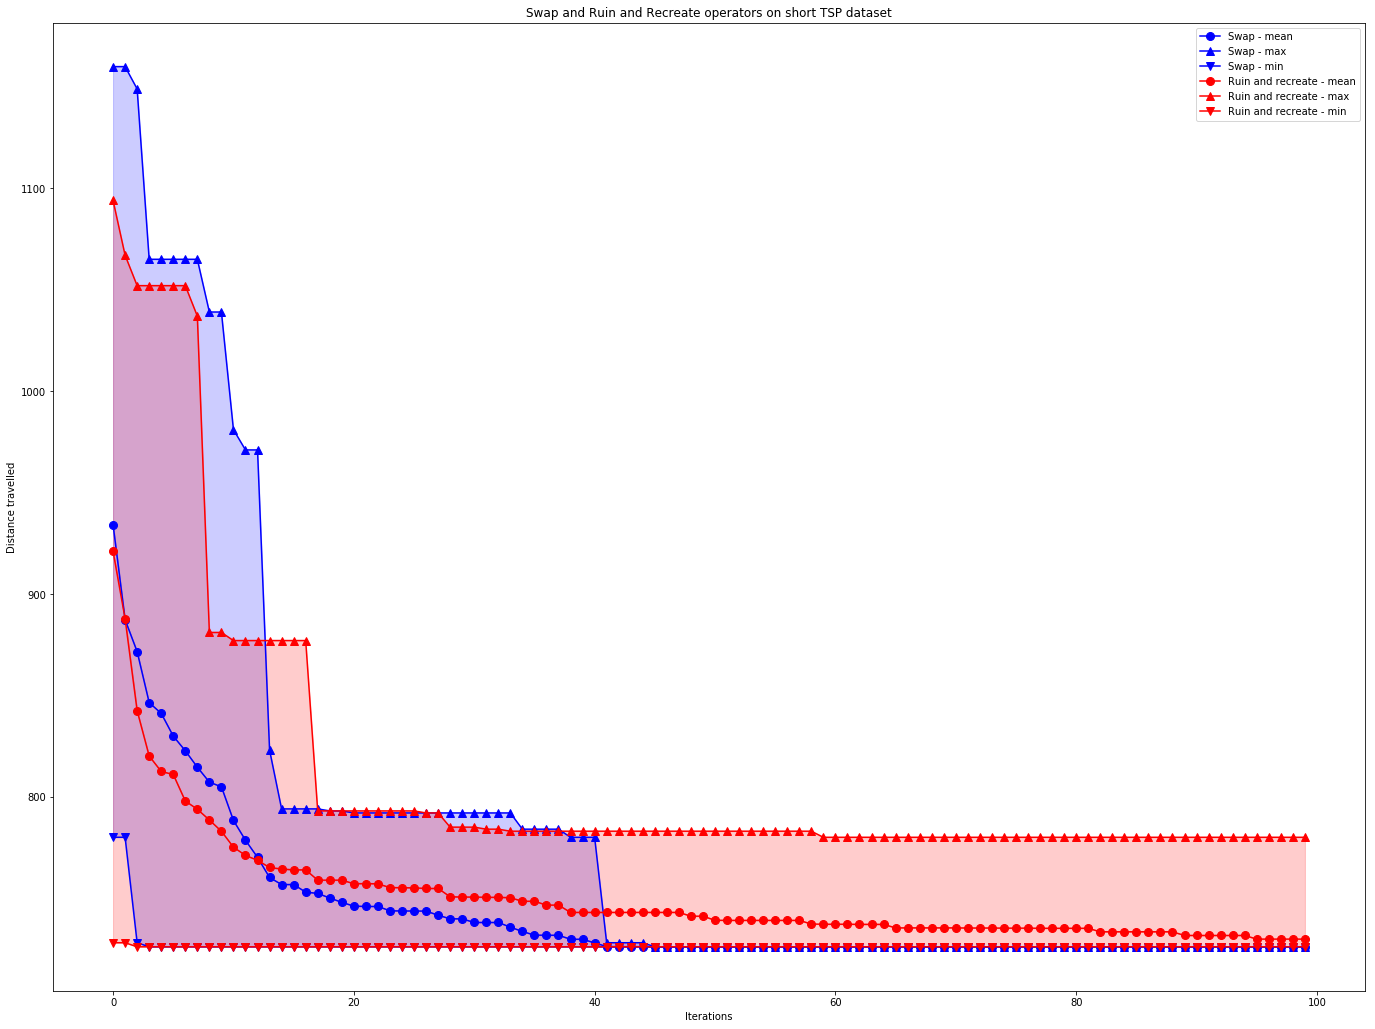

In [36]:
plot_experiment_data(long_swap_experiment, long_rr_experiment, "Swap and Ruin and Recreate operators on long TSP dataset")
plot_experiment_data(short_swap_experiment, short_rr_experiment, "Swap and Ruin and Recreate operators on short TSP dataset")

## Conclusion of optimisation
### Swap performs better than ruin-and-recreate

This can be seen in both datasets - in the long set where there is a greater range of possible answers than the short set, the average score (route length) of the swap operator takes the lead from the ruin-and-recreate operater quickly and proceeds to improve upon the best results from the ruin-and-recreate operator before the end of the experiment.

In the short set where there is a smaller range of possible answers, both operators eventually reach the optimal route - however, the average swap operator still reaches this result significantly faster than the average ruin-and-recreate operator.

Because in both sets the swap operator shows the ability to reach shorter routes at a faster rate than the ruin-and-recreate operator, this shows that the swap operator performs better than the ruin-and-recreate operator.